In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-10-24 20:14:54.065307: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 20:15:01.344653: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 20:15:03.221612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 20:15:03.717583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 20:15:09.325728: I tensorflow/core/platform/cpu_feature_guar

### Generating features

In [ ]:
# load vgg16 model
cnn_model = InceptionV3()
# restructure the model
cnn_model = Model(inputs=cnn_model.inputs, outputs=cnn_model.layers[-2].output)
# summarize
print(cnn_model.summary())

In [ ]:
# Function to preprocess an image
def img_features(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img = img_to_array(img)
    # img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return cnn_model.predict(img)

In [ ]:
features = {}
for img_name in tqdm(os.listdir('./Images/')):
    features[img_name] = img_features(f"./Images/{img_name}")

In [ ]:
pickle.dump(features, open(os.path.join('./', 'features.pkl'), 'wb'))

In [2]:
# load features from pickle
with open(os.path.join('./', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

### Reading Captions

In [3]:
with open(os.path.join('./', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [4]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [5]:
def clean(cap_mapping):
    for img in cap_mapping.keys():
        preprocessed_caps = []
        for cap in cap_mapping[img]:
            cap = cap.lower()
            cap = cap.replace('[^A-Za-z]', '')
            cap = cap.replace(r'\s+', '')
            cap = 'startseq ' + " ".join([word for word in cap.split() if len(word)>1]) + ' endseq'
            preprocessed_caps.append(cap)
        cap_mapping[img] = preprocessed_caps
    return cap_mapping

In [6]:
clean_mapping = clean(mapping)

In [7]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [9]:
vocab_size

8485

In [ ]:
max_length = max([len(cap.split()) for cap in all_captions])
max_length

35

In [11]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [12]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key+'.jpg'][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

### Model Creation

I0000 00:00:1729801105.758573    5524 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729801115.904230    5524 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729801115.904335    5524 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729801115.926752    5524 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729801115.926881    5524 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

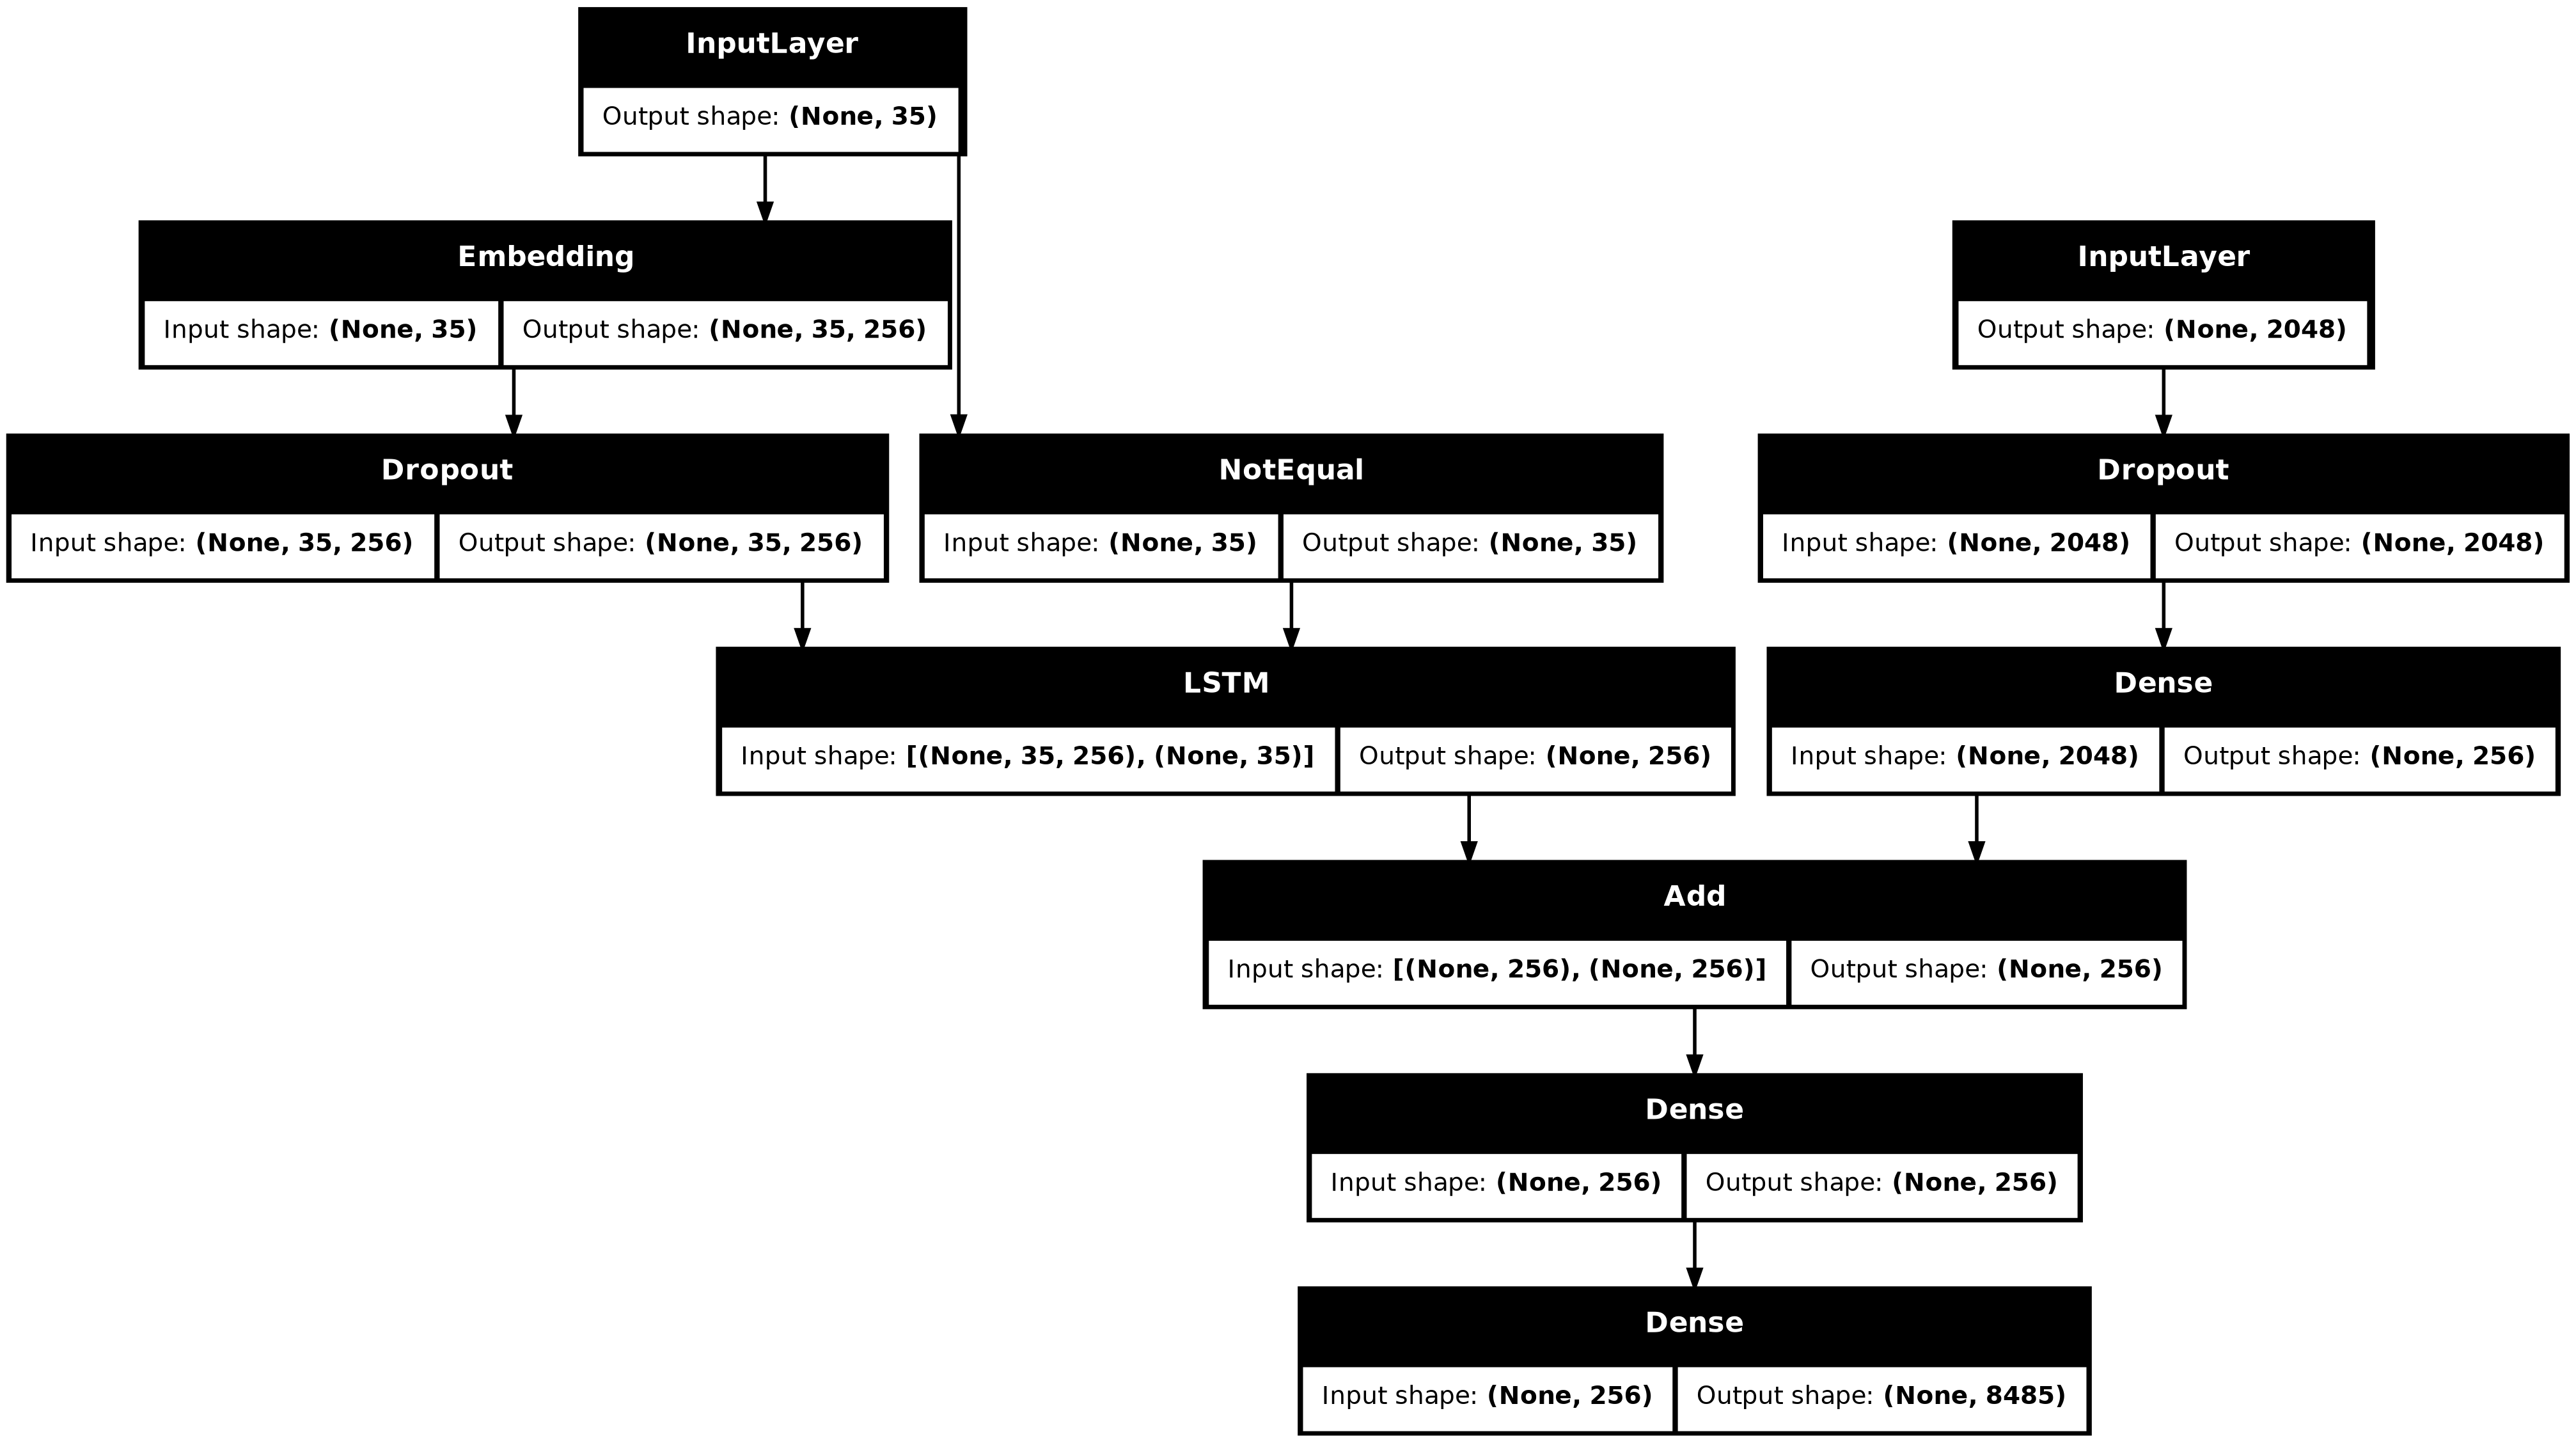

In [13]:
input1 = Input(shape=(2048,), name='image')
fe1 = Dropout(0.25)(input1)
fe2 = Dense(256, activation='relu')(fe1)

input2 = Input(shape=(max_length,), name='text')
se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
se2 = Dropout(0.25)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [14]:
epochs = 10
batch_size = 100
steps = len(train)//batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

/mnt/c/Users/gangw/Learning/Deep learning/Image Captioning/imgcap/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image', 'text']. Received: the structure of inputs={'image': '*', 'text': '*'}
  warnings.warn(
2024-10-24 20:19:00.394305: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 478ms/step - loss: 6.5983
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - loss: 5.0482
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 464ms/step - loss: 4.2092
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 421ms/step - loss: 3.8125
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 469ms/step - loss: 3.5756
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 425ms/step - loss: 3.4069


2024-10-24 20:22:28.704010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 395083008 bytes after encountering the first element of size 395083008 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 428ms/step - loss: 3.2734


2024-10-24 20:23:06.287172: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 395083008 bytes after encountering the first element of size 395083008 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 426ms/step - loss: 3.1673
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 369ms/step - loss: 3.0746
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 413ms/step - loss: 2.9909


In [16]:
# save the model
model.save('./'+'best_model.keras')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None